<a href="https://colab.research.google.com/github/410650377/introduction-to-Computers/blob/main/%E3%80%8CLecture_2_update_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investment Management (L02): Modern Portfolio Theory**
### Author: I-Chan Chiu
This Google Colab notebook is the practical implementation for "Lecture 2: Modern Portfolio Theory." Using real-world data from the Taiwan Stock Exchange, we will implement the foundational concepts of Markowitz portfolio selection, the Capital Allocation Line, the Capital Asset Pricing Model (CAPM), and the Fama-MacBeth two-pass regression to test the model's validity.

## Setup and Data Preparation
### Import Libraries

In [1]:
# @title << Execute this cell to import libraries >>
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## **Upload and Unzip Data**

This cell provides a button to upload a single zip file containing the three required CSVs. The code will then automatically unzip the files into the current Colab environment.

#### **Instructions:**

Prepare a zip file named `TW_Data.zip` containing:

* twstock_daily_2020_2024.csv
* twstock_monthly_2015_2024.csv
* mktrf_1999_2024.csv

Click the "Browse" button below and select your `TW_Data.zip` file.

In [2]:
# @title << Execute this cell to upload and unzip your data >>
from google.colab import files

# Upload the zip file
uploaded = files.upload()

# Assuming the uploaded file
zip_file_name = list(uploaded.keys())[0]

# Unzip the file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('.')

print(f"Successfully unzipped '{zip_file_name}'. The following files are now available:")
print(zip_ref.namelist())

Saving TW_Data.zip to TW_Data.zip
Successfully unzipped 'TW_Data.zip'. The following files are now available:
['mktrf_1999_2024.csv', 'twstock_daily_2020_2024.csv', 'twstock_monthly_2015_2024.csv']


## Load and Preprocess Data

In [3]:
# @title << Execute this cell to load and preprocess data >>

# --- 1. Load Data ---
daily_df = pd.read_csv('twstock_daily_2020_2024.csv')
monthly_df = pd.read_csv('twstock_monthly_2015_2024.csv')
mktrf_df = pd.read_csv('mktrf_1999_2024.csv')


# --- 2. Preprocess Market Factor Data (mktrf_df) ---
# The date column is an object, convert it to a proper period
mktrf_df['year_month'] = pd.to_datetime(mktrf_df['year_month'], format='%Y/%m').dt.to_period('M')

# CRITICAL STEP: The file has multiple entries per month. We group by month and take the mean.
mktrf_df_cleaned = mktrf_df.groupby('year_month').mean().reset_index()
mktrf_df_cleaned.set_index('year_month', inplace=True)


# --- 3. Preprocess Stock Return Data and Reshape ---
def preprocess_and_pivot(df):
    """Converts date, filters, and pivots the dataframe."""
    df['date'] = pd.to_datetime(df['date'])
    # Pivot to wide format: dates as index, stock codes as columns
    df_wide = df.pivot_table(index='date', columns='stock_code', values='RET')
    return df_wide

daily_returns_wide = preprocess_and_pivot(daily_df)
monthly_returns_wide = preprocess_and_pivot(monthly_df)

# Convert monthly index to Period for easier merging with market data
monthly_returns_wide.index = monthly_returns_wide.index.to_period('M')


print("--- Daily Returns (Wide Format) ---")
print(daily_returns_wide.head())
print("\n--- Monthly Returns (Wide Format) ---")
print(monthly_returns_wide.head())
print("\n--- Cleaned Monthly Market Factors ---")
print(mktrf_df_cleaned.head())

--- Daily Returns (Wide Format) ---
stock_code    1101      1102      1103      1104      1108      1109    \
date                                                                     
2020-01-02  0.009153  0.019812  0.000000  0.002551 -0.001193  0.019900   
2020-01-03 -0.003401 -0.002045 -0.026846 -0.010178  0.000000  0.007317   
2020-01-06 -0.011377 -0.010246 -0.006897 -0.010283 -0.019116 -0.004843   
2020-01-07  0.003452  0.001035  0.016204 -0.002597  0.002436 -0.007299   
2020-01-08 -0.004587  0.004137 -0.029613 -0.007812 -0.009721 -0.004902   

stock_code    1110      1201      1203      1210    ...    9958      910322  \
date                                                ...                       
2020-01-02 -0.005731  0.003992  0.009242 -0.010309  ...  0.005540 -0.019231   
2020-01-03  0.000000 -0.001988  0.000000 -0.017361  ... -0.016529  0.000000   
2020-01-06 -0.005764 -0.009960 -0.005495 -0.010601  ... -0.004202  0.000000   
2020-01-07  0.005797 -0.010060 -0.001842  0.023810

## **Markowitz Portfolio Theory**
This section covers the core concepts of Markowitz's mean-variance framework, starting with a simple two-asset portfolio and extending to the multi-asset efficient frontier.

### **Two-Asset Portfolio: TSMC (2330) vs. MediaTek (2454)**
We'll use TSMC and MediaTek to illustrate the principles of diversification.

--- Annualized Inputs for 2330 (TSMC) and 2454 (MediaTek) ---
TSMC: E[R] = 30.79%, St.Dev = 29.06%
MediaTek: E[R] = 38.25%, St.Dev = 39.48%
Correlation (rho): 0.5640

--- Global Minimum-Variance (GMV) Portfolio ---
Weight on TSMC: 82.20%
Weight on MediaTek: 17.80%
GMV Return: 32.12%, GMV Volatility: 28.45%



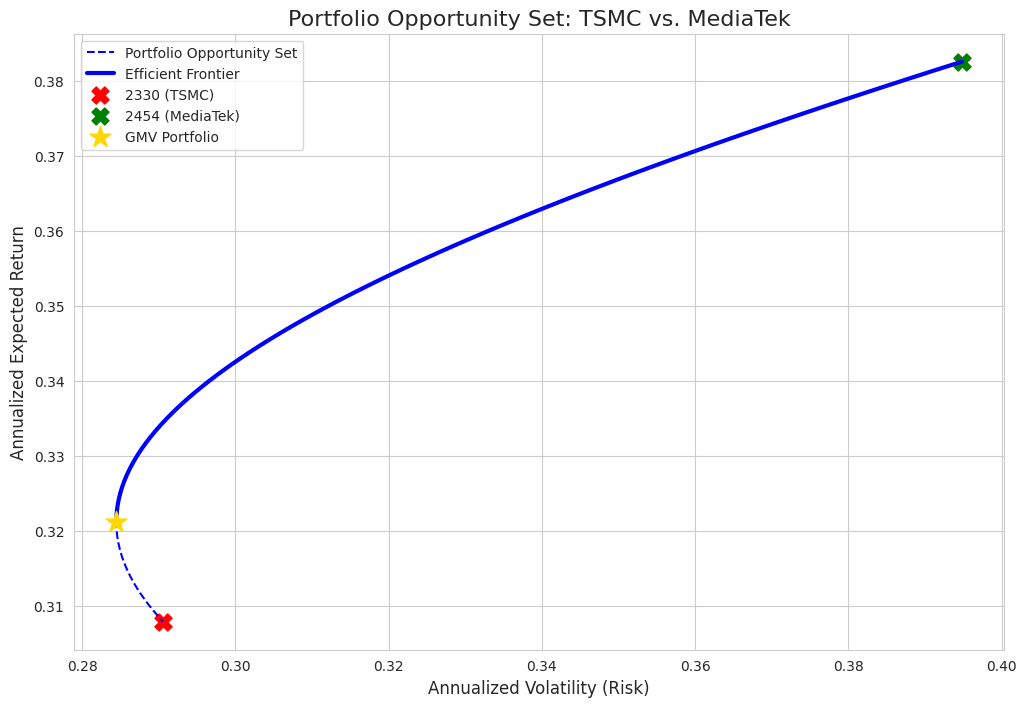

In [4]:
# @title << Two-Asset Portfolio Analysis: TSMC vs. MediaTek >>

# --- 1. Select Assets and Calculate Inputs ---
asset1_code = 2330 # TSMC
asset2_code = 2454 # MediaTek

# Get the return series for the two assets and drop any missing values for the pair
two_assets_df = daily_returns_wide[[asset1_code, asset2_code]].dropna()

# Annualize returns (252 trading days)
annual_returns = two_assets_df.mean() * 252
cov_matrix = two_assets_df.cov() * 252
corr_matrix = two_assets_df.corr()

mu1, mu2 = annual_returns[asset1_code], annual_returns[asset2_code]
sigma1, sigma2 = np.sqrt(cov_matrix.loc[asset1_code, asset1_code]), np.sqrt(cov_matrix.loc[asset2_code, asset2_code])
rho = corr_matrix.loc[asset1_code, asset2_code]

print(f"--- Annualized Inputs for {asset1_code} (TSMC) and {asset2_code} (MediaTek) ---")
print(f"TSMC: E[R] = {mu1:.2%}, St.Dev = {sigma1:.2%}")
print(f"MediaTek: E[R] = {mu2:.2%}, St.Dev = {sigma2:.2%}")
print(f"Correlation (rho): {rho:.4f}\n")


# --- 2. Generate Portfolio Opportunity Set ---
portfolio_returns = []
portfolio_vols = []
weights_range = np.linspace(0, 1, 101) # Weights for asset 1 from 0% to 100%

for w1 in weights_range:
    w2 = 1 - w1
    p_return = w1 * mu1 + w2 * mu2
    p_var = w1**2 * sigma1**2 + w2**2 * sigma2**2 + 2 * w1 * w2 * rho * sigma1 * sigma2
    p_vol = np.sqrt(p_var)
    portfolio_returns.append(p_return)
    portfolio_vols.append(p_vol)


# --- 3. Calculate Global Minimum-Variance (GMV) Portfolio ---
w_gmv = (sigma2**2 - rho * sigma1 * sigma2) / (sigma1**2 + sigma2**2 - 2 * rho * sigma1 * sigma2)
gmv_return = w_gmv * mu1 + (1 - w_gmv) * mu2
gmv_vol = np.sqrt(w_gmv**2 * sigma1**2 + (1-w_gmv)**2 * sigma2**2 + 2*w_gmv*(1-w_gmv)*rho*sigma1*sigma2)

print(f"--- Global Minimum-Variance (GMV) Portfolio ---")
print(f"Weight on TSMC: {w_gmv:.2%}")
print(f"Weight on MediaTek: {1-w_gmv:.2%}")
print(f"GMV Return: {gmv_return:.2%}, GMV Volatility: {gmv_vol:.2%}\n")


# --- 4. Plot the Opportunity Set and GMV ---
plt.figure(figsize=(12, 8))
# Plot the full opportunity set
plt.plot(portfolio_vols, portfolio_returns, 'b--', label='Portfolio Opportunity Set')

# Plot the efficient frontier (upper branch)
efficient_mask = np.array(portfolio_returns) >= gmv_return
plt.plot(np.array(portfolio_vols)[efficient_mask], np.array(portfolio_returns)[efficient_mask], 'b-', lw=3, label='Efficient Frontier')

# Plot individual assets and GMV
plt.scatter(sigma1, mu1, marker='X', color='red', s=150, label=f'{asset1_code} (TSMC)')
plt.scatter(sigma2, mu2, marker='X', color='green', s=150, label=f'{asset2_code} (MediaTek)')
plt.scatter(gmv_vol, gmv_return, marker='*', color='gold', s=250, zorder=5, label='GMV Portfolio')

plt.title('Portfolio Opportunity Set: TSMC vs. MediaTek', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## **Risk-Free Asset, CAL, and the Tangency Portfolio**
Now, we introduce a risk-free asset and find the single optimal risky portfolio that all investors should hold, according to Tobin's Separation Theorem.

Assumed Annualized Risk-Free Rate (rf): 1.71%

--- Tangency Portfolio (Optimal Risky Portfolio) ---
Weight on TSMC: 64.30%
Weight on MediaTek: 35.70%
Tangency Return: 33.46%, Tangency Volatility: 29.06%
Max Sharpe Ratio: 1.0921



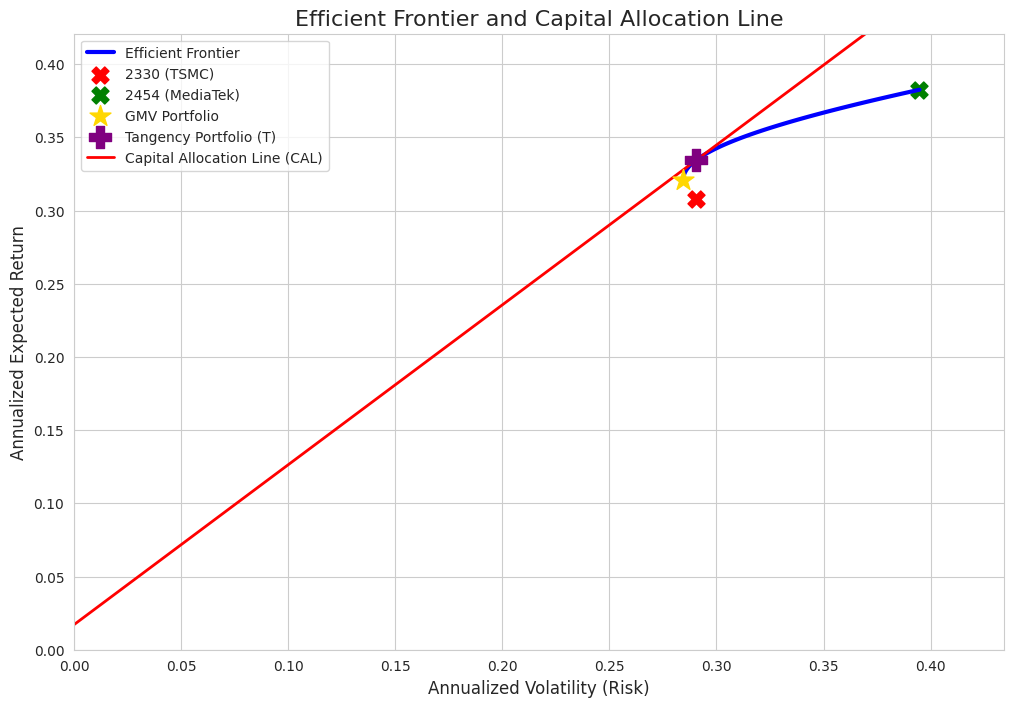

In [5]:
# @title << Calculate and Plot the Capital Allocation Line (CAL) >>

# --- 1. Define Risk-Free Rate ---
# We use the average of the last year's monthly RF from our data, and annualize it.
# This makes the assumption more data-driven.
last_year_rf = mktrf_df_cleaned['rf'].iloc[-12:].mean()
rf = (1+last_year_rf)**12 - 1 # EAR
print(f"Assumed Annualized Risk-Free Rate (rf): {rf:.2%}\n")


# --- 2. Calculate Tangency Portfolio (Two-Asset Case) ---
delta1 = mu1 - rf
delta2 = mu2 - rf
numerator = delta1 * sigma2**2 - delta2 * rho * sigma1 * sigma2
denominator = delta1 * (sigma2**2 - rho * sigma1 * sigma2) + delta2 * (sigma1**2 - rho * sigma1 * sigma2)
w_tan = numerator / denominator

tan_return = w_tan * mu1 + (1 - w_tan) * mu2
tan_vol = np.sqrt(w_tan**2 * sigma1**2 + (1-w_tan)**2 * sigma2**2 + 2*w_tan*(1-w_tan)*rho*sigma1*sigma2)
tan_sharpe = (tan_return - rf) / tan_vol

print(f"--- Tangency Portfolio (Optimal Risky Portfolio) ---")
print(f"Weight on TSMC: {w_tan:.2%}")
print(f"Weight on MediaTek: {1-w_tan:.2%}")
print(f"Tangency Return: {tan_return:.2%}, Tangency Volatility: {tan_vol:.2%}")
print(f"Max Sharpe Ratio: {tan_sharpe:.4f}\n")


# --- 3. Plot the CAL ---
plt.figure(figsize=(12, 8))
# Plot Efficient Frontier and key points as before
plt.plot(np.array(portfolio_vols)[efficient_mask], np.array(portfolio_returns)[efficient_mask], 'b-', lw=3, label='Efficient Frontier')
plt.scatter(sigma1, mu1, marker='X', color='red', s=150, label=f'{asset1_code} (TSMC)')
plt.scatter(sigma2, mu2, marker='X', color='green', s=150, label=f'{asset2_code} (MediaTek)')
plt.scatter(gmv_vol, gmv_return, marker='*', color='gold', s=250, zorder=3, label='GMV Portfolio')

# Plot the Tangency Portfolio
plt.scatter(tan_vol, tan_return, marker='P', color='purple', s=250, zorder=5, label='Tangency Portfolio (T)')

# Plot the Capital Allocation Line (CAL)
cal_x = np.linspace(0, sigma1 * 1.5, 100)
cal_y = rf + tan_sharpe * cal_x
plt.plot(cal_x, cal_y, 'r-', lw=2, label='Capital Allocation Line (CAL)')

plt.title('Efficient Frontier and Capital Allocation Line', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.xlim(0, max(sigma1, sigma2) * 1.1)
plt.ylim(0, max(mu1, mu2) * 1.1)
plt.legend()
plt.grid(True)
plt.show()

## **Multi-Asset Efficient Frontier**
Here we extend the analysis to a portfolio of multiple assets using the closed-form matrix algebra solution.

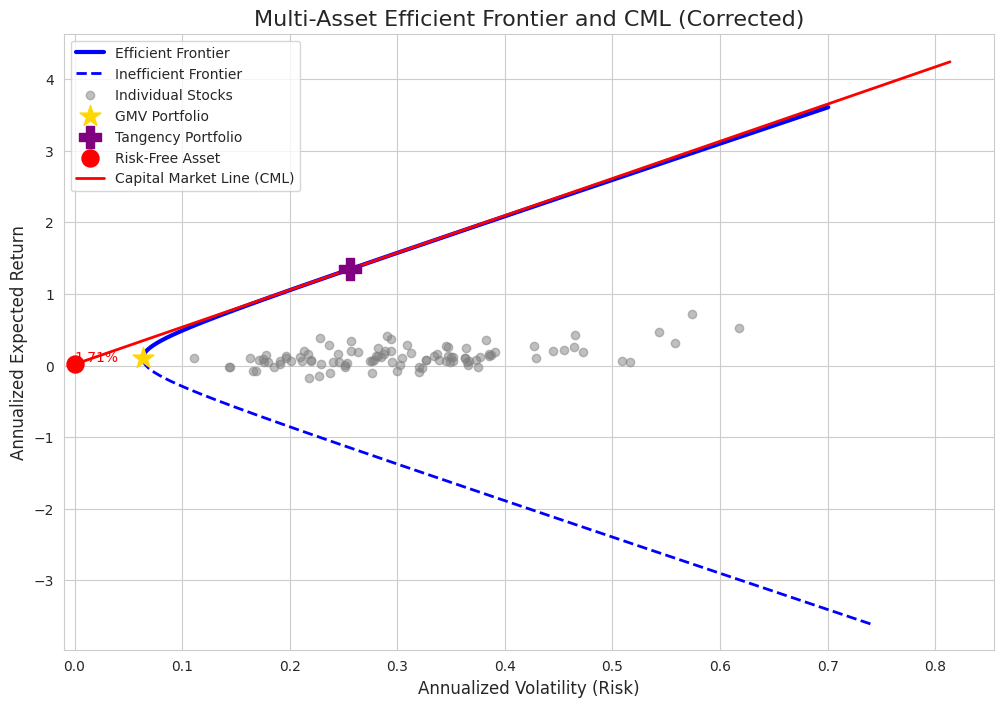

In [6]:
# @title << Multi-Asset Efficient Frontier (Final Corrected Code) >>

# --- 1. Setup Asset Universe ---
N_STOCKS = 100
top_stocks = daily_returns_wide.count().nlargest(N_STOCKS).index
multi_asset_df = daily_returns_wide[top_stocks].dropna()

# --- CODE CORRECTION: Ensure all inputs are NumPy arrays for consistent matrix algebra ---
E = (multi_asset_df.mean() * 252).values
Sigma = (multi_asset_df.cov() * 252).values
# --- END CORRECTION ---

Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(N_STOCKS)


# --- 2. Calculate Frontier using Matrix Algebra ---
A = E.T @ Sigma_inv @ E
B = E.T @ Sigma_inv @ ones
C = ones.T @ Sigma_inv @ ones
Delta = A * C - B**2
mu_gmv = B / C
sigma_gmv = np.sqrt(1 / C)

# Define a plotting range for the frontier curve
plot_range_max = E.max() * 5
mu_p = np.linspace(-plot_range_max, plot_range_max, 1000)
var_p = (C * mu_p**2 - 2 * B * mu_p + A) / Delta
valid_mask = var_p >= 0
sigma_p = np.sqrt(var_p[valid_mask])
mu_p = mu_p[valid_mask]


# --- 3. Find Multi-Asset Tangency Portfolio using CORRECT formulas ---
excess_returns_vec = E - rf
w_tan_num = Sigma_inv @ excess_returns_vec
w_tan_den = ones.T @ Sigma_inv @ excess_returns_vec
w_tan_multi = w_tan_num / w_tan_den

# --- CODE CORRECTION: Calculate return and volatility DIRECTLY from the weights ---
# This is the most direct way and avoids any previous patching errors.
tan_return_multi = w_tan_multi.T @ E
tan_vol_multi = np.sqrt(w_tan_multi.T @ Sigma @ w_tan_multi)
# --- END CORRECTION ---
tan_sharpe_multi = (tan_return_multi - rf) / tan_vol_multi


# --- 4. Plot the Corrected Results ---
mid = np.argmin(sigma_p)
sigma_upper, mu_upper = sigma_p[mid:], mu_p[mid:]
sigma_lower, mu_lower = sigma_p[:mid+1], mu_p[:mid+1]

plt.figure(figsize=(12, 8))
plt.plot(sigma_upper, mu_upper, 'b-', lw=3, label='Efficient Frontier')
plt.plot(sigma_lower, mu_lower, 'b--', lw=2, label='Inefficient Frontier')

plt.scatter(np.sqrt(np.diag(Sigma)), E, marker='o', color='grey', alpha=0.5, label='Individual Stocks')
plt.scatter(sigma_gmv, mu_gmv, marker='*', color='gold', s=250, zorder=5, label='GMV Portfolio')
plt.scatter(tan_vol_multi, tan_return_multi, marker='P', color='purple', s=250, zorder=5, label='Tangency Portfolio')

plt.scatter(0, rf, marker='o', color='red', s=150, zorder=5, label='Risk-Free Asset')
plt.text(0, rf, f"{rf:.2%}", ha='left', va='bottom', fontsize=10, color='red')

cal_x_multi = np.linspace(0, sigma_p.max() * 1.1, 100)
cal_y_multi = rf + tan_sharpe_multi * cal_x_multi
plt.plot(cal_x_multi, cal_y_multi, 'r-', lw=2, label='Capital Market Line (CML)')

plt.title('Multi-Asset Efficient Frontier and CML (Corrected)', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.legend()
plt.grid(True)
plt.xlim(left=-0.01)
plt.ylim(bottom=mu_p.min()*1.1)   # 自動確保有負值
plt.show()


 ## **Capital Asset Pricing Model (CAPM)**
 We now switch to monthly data to explore the equilibrium implications of portfolio theory, focusing on the CAPM and the relationship between systematic risk and expected returns.

### **Data Preparation: Calculating Excess Returns**
The foundation of CAPM analysis is excess returns (returns in excess of the risk-free rate).

In [7]:
# @title << Calculate Monthly Excess Returns >>

# Merge monthly stock returns with the cleaned market factor data
capm_df = monthly_returns_wide.join(mktrf_df_cleaned, how='inner')

# Extract market excess return and risk-free rate
mkt_excess = capm_df['mktrf']
rf = capm_df['rf']

# Calculate stock excess returns by subtracting the risk-free rate from each stock's return column
stock_returns = capm_df.drop(columns=['mktrf', 'rf', 'mkt'])
rets_excess = stock_returns.subtract(rf, axis=0)

print("--- Asset Excess Returns (First 5 rows) ---")
print(rets_excess.head())
print("\n--- Market Excess Returns (First 5 rows) ---")
print(mkt_excess.head())

--- Asset Excess Returns (First 5 rows) ---
           1101      1102      1103      1104      1108      1109      1110    \
2015-01 -0.019564 -0.024206 -0.018797  0.045382 -0.015694  0.021341 -0.024658   
2015-02  0.007086  0.014619 -0.022712 -0.017795  0.003797  0.006197  0.001883   
2015-03  0.025646  0.015665  0.013579  0.109983  0.077302  0.009781  0.001874   
2015-04 -0.012470 -0.015106  0.027858  0.109039  0.007964 -0.001130  0.049771   
2015-05 -0.044705  0.001448 -0.053944 -0.117159  0.016889 -0.022713 -0.129335   

           1201      1203      1210    ...    911611    911612    911616  \
2015-01  0.034872 -0.007432  0.013390  ...  0.285911 -0.009495  0.202180   
2015-02 -0.024295 -0.003244 -0.017229  ... -0.011921 -0.174125 -0.075785   
2015-03 -0.011011  0.007349 -0.046585  ... -0.172039 -0.393985 -0.081808   
2015-04 -0.041049  0.007276 -0.048749  ... -0.242358  0.217357 -0.098127   
2015-05 -0.090527 -0.030297 -0.053130  ... -0.139856 -0.132162  0.042349   

           9

## **Estimating Beta and Alpha: The Security Characteristic Line (SCL)**

The SCL is a time-series regression that quantifies an asset's systematic risk (
beta) and its abnormal performance (alpha) relative to the market.

\begin{align}
r_{i,t}-r_{f,t}=\alpha_i+\beta_i(r_{M,t}-r_{f,t})+\epsilon_{i,t}
\end{align}

--- SCL Regression Results for TSMC (2330) ---
                            OLS Regression Results                            
Dep. Variable:                   2330   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     292.2
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           1.02e-33
Time:                        15:23:42   Log-Likelihood:                 220.25
No. Observations:                 120   AIC:                            -436.5
Df Residuals:                     118   BIC:                            -430.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

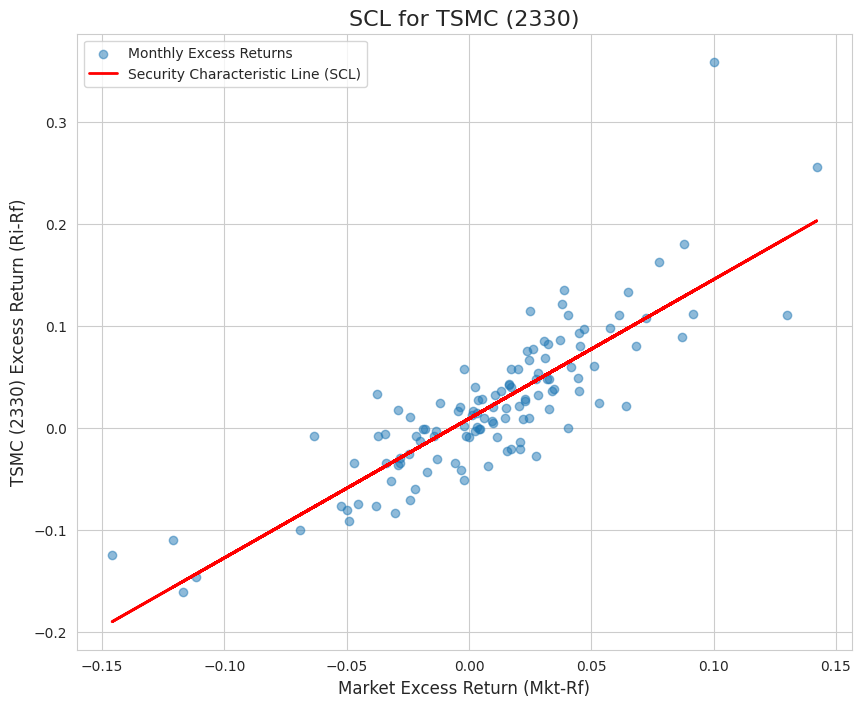

In [8]:
# @title << Estimate and Visualize the SCL for TSMC (2330) >>

# Select a single stock to analyze, e.g., TSMC
asset_code = 2330
asset_excess_returns = rets_excess[asset_code].dropna()

# Align the market data with the asset data
market_excess_returns = mkt_excess.loc[asset_excess_returns.index]

# Add a constant (for the intercept alpha)
X = sm.add_constant(market_excess_returns)
y = asset_excess_returns

# Run the OLS regression
model = sm.OLS(y, X).fit()

# Extract alpha and beta
alpha, beta = model.params
print(f"--- SCL Regression Results for TSMC ({asset_code}) ---")
print(model.summary())
print("\n")
print(f"Estimated Alpha: {alpha:.4f} (monthly)")
print(f"Estimated Beta: {beta:.4f}")

# Visualize the SCL
plt.figure(figsize=(10, 8))
plt.scatter(market_excess_returns, asset_excess_returns, alpha=0.5, label='Monthly Excess Returns')
plt.plot(market_excess_returns, alpha + beta * market_excess_returns, color='red', lw=2, label='Security Characteristic Line (SCL)')
plt.title(f'SCL for TSMC ({asset_code})', fontsize=16)
plt.xlabel('Market Excess Return (Mkt-Rf)', fontsize=12)
plt.ylabel(f'TSMC ({asset_code}) Excess Return (Ri-Rf)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

 ## **Systematic vs. Idiosyncratic Risk Decomposition**
 Using the SCL regression results, we can decompose an asset's total risk into two parts: the systematic risk that is correlated with the market, and the idiosyncratic risk that is unique to the firm.

\begin{align}
Var(r_i)=\beta_i^2Var(r_M)+Var(\varepsilon_i)
\end{align}

In [9]:
# @title << Decompose Total Risk for TSMC (2330) >>
# Total variance of the stock's excess return
total_variance = asset_excess_returns.var()

# Systematic variance
market_variance =market_excess_returns.var()
systematic_variance =(beta**2)*market_variance

# Idiosyncratic variance (variance of the residuals)
idiosyncratic_variance =model.resid.var()

# R-squared is the proportion of systematic variance
r_squared = model.rsquared

print(f"--- Risk Decomposition for TSMC ({asset_code}) ---")
print(f"Total Variance:           {total_variance:.6f} (100%)")
print(f"Systematic Variance:      {systematic_variance:.6f} ({systematic_variance/total_variance:.2%})")
print(f"Idiosyncratic Variance:   {idiosyncratic_variance:.6f} ({idiosyncratic_variance/total_variance:.2%})")
print(f"\nNote: The proportion of systematic variance is equal to the R-squared of the SCL regression: {r_squared:.2%}")

--- Risk Decomposition for TSMC (2330) ---
Total Variance:           0.005225 (100%)
Systematic Variance:      0.003722 (71.24%)
Idiosyncratic Variance:   0.001503 (28.76%)

Note: The proportion of systematic variance is equal to the R-squared of the SCL regression: 71.24%


## **The Security Market Line (SML): Theory vs. Reality**
The SML is the graphical representation of the CAPM, plotting expected return against systematic risk (beta). According to the theory, all assets should lie on this line.

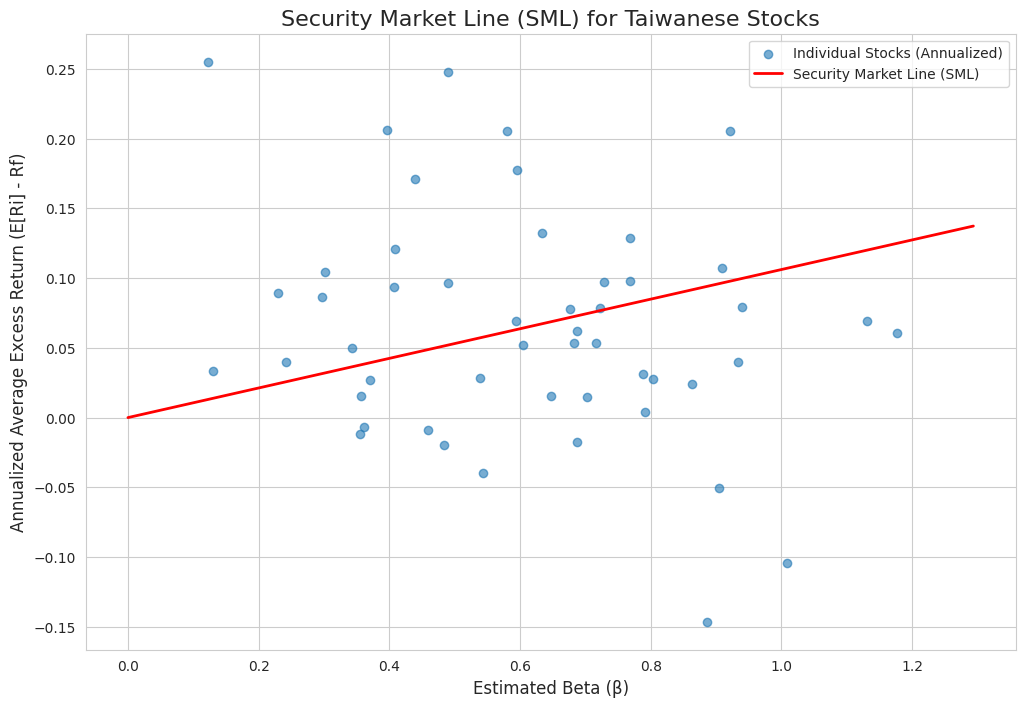

In [10]:
# @title << Plot the Security Market Line (SML) >>

# --- 1. Estimate Betas for all stocks ---
# Use a subset of stocks with good data for clarity
num_stocks_for_sml = 50
top_stocks_monthly = monthly_returns_wide.count().nlargest(num_stocks_for_sml).index
rets_excess_sml = rets_excess[top_stocks_monthly]

betas = {}
alphas = {}
avg_excess_returns = rets_excess_sml.mean()

for stock in rets_excess_sml.columns:
  #input your code
  stock_returns=rets_excess_sml[stock].dropna()
  market_ret=mkt_excess.loc[stock_returns.index]
  X=sm.add_constant(market_ret)
  model=sm.OLS(stock_returns,X).fit()
  alphas[stock]=model.params['const']
  betas[stock]=model.params['mktrf']
beta_series = pd.Series(betas, name='Beta')


# --- 2. Plot the SML ---
plt.figure(figsize=(12, 8))

# Plot the individual stocks (Beta vs. Avg. Excess Return)
plt.scatter(beta_series, avg_excess_returns * 12, alpha=0.6, label='Individual Stocks (Annualized)') # Annualize for plotting

# Plot the theoretical SML
avg_market_excess_return = mkt_excess.mean()
sml_x = np.linspace(0, beta_series.max() * 1.1, 100)
sml_y = sml_x * avg_market_excess_return * 12 # Annualize for plotting

plt.plot(sml_x, sml_y, color='red', lw=2, label='Security Market Line (SML)')

plt.title('Security Market Line (SML) for Taiwanese Stocks', fontsize=16)
plt.xlabel('Estimated Beta (β)', fontsize=12)
plt.ylabel('Annualized Average Excess Return (E[Ri] - Rf)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## **CAPM Empirical Test: Fama-MacBeth Regression**

This section implements the Fama-MacBeth (1973) procedure using the professional `linearmodels` package to formally test if the CAPM holds in the Taiwanese stock market.

In [11]:
# @title << Fama-MacBeth (Classic Implementation as per Reference) >>

# --- 1. Select Universe and Estimate Rolling Betas ---
# This part is still necessary to get the time-varying betas (our characteristic)
NUM_STOCKS_FM = 100
ROLLING_WINDOW = 36

top_stocks_fm = monthly_returns_wide.count().nlargest(NUM_STOCKS_FM).index
rets_excess_fm = rets_excess[top_stocks_fm].dropna(axis=1, how='all')

# Use a more efficient method to calculate rolling betas
print(f"Estimating rolling {ROLLING_WINDOW}-month betas for individual stocks...")
def rolling_beta_func(y, x):
    if len(y.dropna()) < 20: return np.nan
    X = sm.add_constant(x)
    return sm.OLS(y, X).fit().params.get('mktrf', np.nan)

betas = rets_excess_fm.rolling(ROLLING_WINDOW).apply(
    lambda y: rolling_beta_func(y, mkt_excess.loc[y.index]), raw=False
).shift(1) # Shift(1) to use past betas to predict current returns
print("Rolling beta estimation complete.")


# --- 2. Prepare Data for Monthly Regressions ---
# We need to align returns (y) with their corresponding pre-estimated betas (x)
# We stack them into a long-format DataFrame for easy grouping.
panel_data = pd.DataFrame({
    'ret_excess': rets_excess_fm.stack(),
    'beta': betas.stack()
}).dropna()
panel_data.index.names = ['date', 'stock_code']
panel_data.reset_index(inplace=True)


# --- 3. Run Cross-Sectional Regressions for Each Month ---
# This is the core of the Fama-MacBeth procedure, as shown in your reference.
print("Running monthly cross-sectional regressions...")

def cs_regression(df):
    # For each month's data, run OLS of returns on beta
    y = df['ret_excess']
    X = sm.add_constant(df['beta'])
    model = sm.OLS(y, X).fit()
    return model.params

# Group by date and apply the regression function to each group
gamma_series = panel_data.groupby('date').apply(cs_regression)
print("Monthly regressions complete.")


# --- 4. Time-Series Aggregation and Inference ---
# Calculate the time-series average of the coefficients (the risk premia)
avg_premia = gamma_series.mean()
# Calculate Fama-MacBeth t-statistics
std_err = gamma_series.std()
t_stats = avg_premia / (std_err / np.sqrt(len(gamma_series)))

# Present the final results
results_df = pd.DataFrame({
    'Average Premium (γ)': avg_premia,
    'Fama-MacBeth t-statistic': t_stats
})
results_df.rename(index={'const': 'Gamma_0 (Intercept)', 'beta': 'Gamma_M (Market Premium)'}, inplace=True)

print("\n\n--- Fama-MacBeth Two-Pass Regression Results ---")
print(results_df)
print(f"\nFor comparison, the actual average market premium was: {mkt_excess.mean():.4f} (monthly).")

Estimating rolling 36-month betas for individual stocks...
Rolling beta estimation complete.
Running monthly cross-sectional regressions...
Monthly regressions complete.


--- Fama-MacBeth Two-Pass Regression Results ---
                          Average Premium (γ)  Fama-MacBeth t-statistic
Gamma_0 (Intercept)                  0.007915                  1.772446
Gamma_M (Market Premium)            -0.001497                 -0.331490

For comparison, the actual average market premium was: 0.0088 (monthly).


/tmp/ipython-input-1730180249.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gamma_series = panel_data.groupby('date').apply(cs_regression)
